In [71]:
from os.path import exists, join, isfile
from os import listdir, makedirs
from obspy.geodetics import kilometer2degrees
import numpy as np
from obspy.taup import TauPyModel
import matplotlib.pyplot as plt
from SS_MTI import Inversion

import threading
import subprocess

import Create_Vmod
from SS_MTI import Gradient, PhaseTracer, Misfit

# Fixed parameters (initial model)

In [6]:
bin_filepath = "/home/nienke/Documents/Research/SS_MTI/External_packages/reflectivity_Mars/SRC/test/crfl_sac"
save_path_OG = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic"
if not exists(join(save_path_OG, "start_v")):
    makedirs(join(save_path_OG, "start_v"))
f_start = join(save_path_OG, "start_v")

## Fixed parameters:
src_depth = 20.0
epi_in_km = 1774.7380
epi = kilometer2degrees(epi_in_km, radius=3389.5)
baz = 0.0

dt = 0.025

phases = ["P", "S", "P", "S", "S"]
comps = ["Z", "T", "R", "Z", "R"]
t_pres = [1, 1, 1, 1, 1]
t_posts = [30, 30, 30, 30, 30]
ylims = [2e-10, 2e-10, 1e-10, 3e-10, 2e-10]

fmin = 0.2
fmax = 0.6
zerophase = False


## Start parameters:
bm_start_model = "/home/nienke/Documents/Research/Data/MTI/MT_vs_STR/bm_models/TAYAK.bm"
m_rr = 0.3000
m_tt = 0.1000 
m_pp = 0.2000
m_rt = 0.2000
m_rp = 0.5000
m_tp = 0.2000
# mtt,mtp,mrt,mpp,mrp,mrr = 0.1000    0.2000    0.2000    0.1000    0.1000    0.2000 # TRUE MODEL


focal_mech = [m_rr, m_tt, m_pp, m_rt, m_rp, m_tp]
Moho_d = 75.0
m0 = np.hstack((focal_mech, Moho_d))
sigmas = np.ones(len(phases)) * 1e-10

Create_Vmod.create_dat_file(
    src_depth, epi_in_km, baz, focal_mech, dt, f_start, bm_start_model,
)
Create_Vmod.update_dat_file(
    dat_folder=f_start,
    m=m0,
    vpvs=False,
    depth=True,
    produce_tvel= True,
    tvel_name = "Init",
)

depth of MOHO (from TAYAK) will be changed


/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))
/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:298: RuntimeWarning: invalid value encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))


In [3]:
m0

array([  0.3,   0.1,   0.2,   0.2,   0.5,   0.2,  75. ])

# Observed data

In [4]:
path_observed = (
    "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/obs_2/"
)
npz_file = "/home/nienke/Documents/Research/Data/npz_files/TAYAK.npz"
st_obs = Gradient.read_refl_mseeds(path=path_observed)
Taup = TauPyModel(npz_file)
obs_tts = [PhaseTracer.get_traveltime(Taup, phase, src_depth, epi) for phase in phases]
st_obs_w, st_obs_full, s_obs = Gradient.window(
    st_obs, phases, comps, obs_tts, t_pres, t_posts, fmin, fmax, zerophase,
)

# Classic gradient descent

# 

In [48]:
update_nr = 25
current_update = 15

epsilon = 0.001
prior_crfl_filepath = join(f_start, "crfl.dat")
Inversion.gradient_descent(
    bin_path=bin_filepath,
    save_path=save_path_OG,
    epsilon=epsilon,
    update_nr=update_nr,
    dt=dt,
    sigmas=sigmas,
    st_obs_w=st_obs_w,
    current_update=current_update,
    prior_crfl_filepath=None,
    alphas=[1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1],
    fmin=fmin,
    fmax=fmax,
    phases=phases,
    comps=comps,
    t_pres=t_pres,
    t_posts=t_posts,
)

Forward run + misfit calc for m: [  0.17155801   0.07807256   0.2          0.16605271   0.07805169
  -0.13982469  75.33353196]
75.3335319577
forward run in iteration: 0
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_15/It_0/75.33353195774892.tvel' ...
63.1728349972
Forward run + misfit calc for m: [  0.17165033   0.07807256   0.2          0.16605271   0.07805169
  -0.13982469  75.33353196]
75.3335319577
forward run in iteration: 1
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_15/It_1/75.33353195774892.tvel' ...
63.1738912229
Forward run + misfit calc for m: [  0.17155801   0.07816488   0.2          0.16605271   0.07805169
  -0.13982469  75.33353196]
75.3335319577
forward run in iteration: 2
depth of MOHO (from TAYAK) will

Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_16/It_4/75.33963446313611.tvel' ...
62.8007841244
Forward run + misfit calc for m: [  0.16011689   0.08291045   0.2          0.16605271   0.07813895
  -0.1635243   75.33963446]
75.3396344631
forward run in iteration: 5
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_16/It_5/75.33963446313611.tvel' ...
62.8007841244
Forward run + misfit calc for m: [  0.16011689   0.08291045   0.2          0.16605271   0.07805169
  -0.16343703  75.33963446]
75.3396344631
forward run in iteration: 6
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_16/It_6/75.33963446313611.tvel' ...
62.802292794
Forward run +

Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_17/It_8/75.33906170153435.tvel' ...
62.6564012609
Forward run + misfit calc for m: [  1.71878733e-01   7.28440813e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.72313381e-01   7.53390799e+01]
75.3390798766
forward run in iteration: 9
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_17/It_9/75.33907987657014.tvel' ...
62.6495632933
Forward run + misfit calc for m: [  1.71216107e-01   7.38309376e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.72894129e-01   7.53391607e+01]
75.3391606545
forward run in iteration: 10
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_17/It

Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_18/It_12/75.34010028416009.tvel' ...
62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   6.05782426e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.91463630e-01   7.53401312e+01]
75.340131162
forward run in iteration: 13
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_18/It_13/75.34013116202367.tvel' ...
62.821780371
Forward run + misfit calc for m: [  0.16376157  -0.15861521   0.2          0.16605271   0.07805169
  -0.29978839  75.34068696]
75.3406869636
forward run in iteration: 14
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_18/It_14/75.34068696356827.tvel' .

67.4118400361
forward run in iteration: 16
depth of MOHO (from TAYAK) will be changed
this is the iteration used for next update: 16
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-01   7.53400991e+01]
75.3400990647
forward run in iteration: 0
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_20/It_0/75.3400990646727.tvel' ...
62.47598015
Forward run + misfit calc for m: [  1.63844095e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-01   7.53400991e+01]
75.3400990647
forward run in iteration: 1
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_20/It_1/75.3400990646727.tvel' ...
62.47598015
Forward run + mis

62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00082529e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-01   7.53400978e+01]
75.3400978452
forward run in iteration: 3
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_21/It_3/75.3400978451853.tvel' ...
62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66135243e-01
   7.80516866e-02  -1.85445588e-01   7.53400978e+01]
75.3400978452
forward run in iteration: 4
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_21/It_4/75.3400978451853.tvel' ...
62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.81342160e-02  -1.85445588e-01  

62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85363058e-01   7.53400966e+01]
75.3400966257
forward run in iteration: 6
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_22/It_6/75.34009662569788.tvel' ...
62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-01   7.53476306e+01]
75.3476306354
forward run in iteration: 7
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_22/It_7/75.34763063536045.tvel' ...
62.4851677802
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-

62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-01   7.53400832e+01]
75.3400832113
forward run in iteration: 9
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_23/It_9/75.34008321133582.tvel' ...
62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-01   7.53400344e+01]
75.3400344318
forward run in iteration: 10
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_23/It_10/75.34003443183735.tvel' ...
62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-

62.47598015
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-01   7.53394844e+01]
75.339484443
forward run in iteration: 12
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_24/It_12/75.33948444298228.tvel' ...
62.4765303779
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445588e-01   7.53388747e+01]
75.3388746992
forward run in iteration: 13
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gradient_descent_classic/Update_24/It_13/75.33887469924157.tvel' ...
62.4765926684
Forward run + misfit calc for m: [  1.63761566e-01   7.27556565e-02   2.00000000e-01   1.66052714e-01
   7.80516866e-02  -1.85445

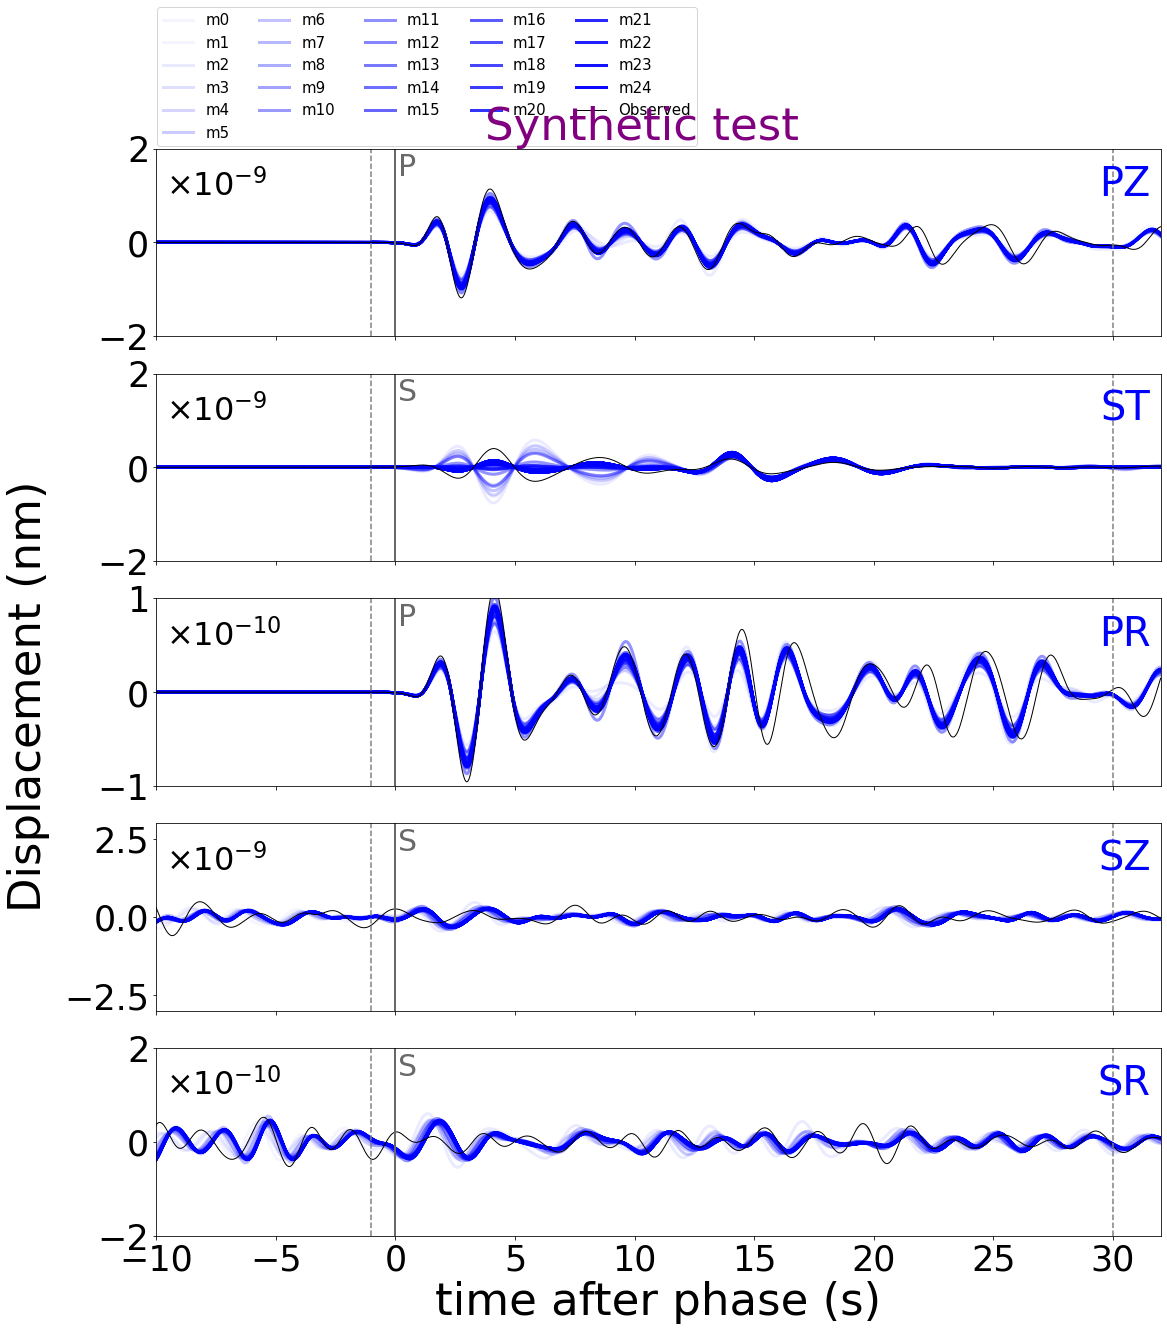

In [7]:
Gradient.plot_updates(
    save_path=save_path_OG,
    st_obs_full=st_obs_full,
    st_obs_w=st_obs_w,
    obs_tts=obs_tts,
    phases=phases,
    comps=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    fmin=fmin,
    fmax=fmax,
    zerophase=zerophase,
    ylims=ylims,
)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


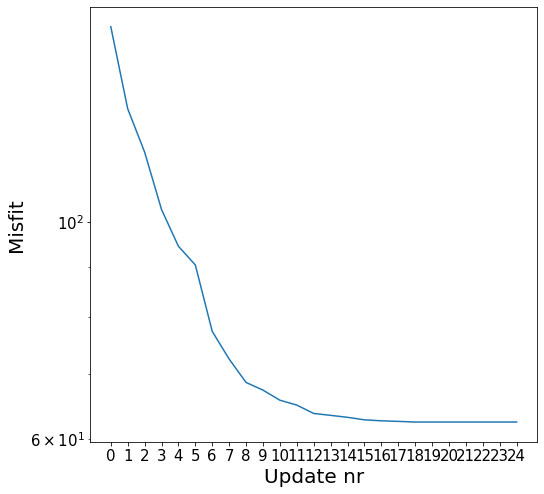

In [8]:
Gradient.plot_misfits(save_path_OG,epsilon=0.001)

# Gaus-Newton method

##  Jacobian calculation

In [63]:
def Exact_gradient(
    thread_folder: str,
    thread_nr: int,
    dat_folder: str,
    unit_v: np.array,
    bin_filepath: str,
):
    print(thread_nr)
    print(unit_v)
    """ Thread worker function """

    """ Copy .dat file into new folder """
    dat_filepath = join(dat_folder, "crfl.dat")
    subprocess.call(f"scp {dat_filepath} .", shell=True, cwd=thread_folder)
    """ Copy binary file into new folder """
    subprocess.call(f"scp {bin_filepath} .", shell=True, cwd=thread_folder)

    """ Plug unit vector into .dat file """
    Create_Vmod.update_dat_file(
        dat_folder=thread_folder,
        m=unit_v,
        vpvs=False,
        depth=False,
        produce_tvel=True,
        tvel_name="exact",
    )

    """ Run the reflectivity code """
    print(f"Running exact gradient on thread: {thread_nr}\n")
    subprocess.call("./crfl_sac", shell=True, cwd=thread_folder)
    print(f"thread: {thread_nr} is done\n")
    np.save(join(thread_folder, "m.npy"), unit_v)


def Get_J_moment(
    save_path: str,
    prior_dat_folder: str,
    bin_file_path: str,
    phases: [str],
    comps: [str],
    t_pres: [float],
    t_posts: [float],
    fmin: float,
    fmax: float,
    zerophase: bool,
):

    unit_vs = np.array(
        (
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1],
        )
    )
    J_approx = []

    threads = []
    dat_folder = prior_dat_folder  # f_start
    """ Creating the exact seismograms: """
    for i in range(6):
        """ Create folder for each thread """
        thread_folder = join(save_path, f"Exact_{i}")
        if not exists(thread_folder):
            makedirs(thread_folder)
        """ Run forward model with each unit vector """
        exact_st = [
            f
            for f in listdir(thread_folder)
            if f.startswith("st00")
            if isfile(join(thread_folder, f))
        ]
        if not exact_st:
            t = threading.Thread(
                target=Exact_gradient,
                args=[thread_folder, i, dat_folder, unit_vs[:, i], bin_filepath],
            )
            threads.append(t)
            t.start()
    if not exact_st:
        for thread in threads:
            thread.join()

    """ Reading in seismograms and substituting into approximate Green's functions: """
    for i in range(6):
        thread_folder = join(save_path, f"Exact_{i}")
        st = Gradient.read_refl_mseeds(path=thread_folder, stack=False)

        """ Window the data """
        npz_name = [
            f
            for f in listdir(thread_folder)
            if f.endswith(".npz")
            if isfile(join(thread_folder, f))
        ]
        if npz_name:
            npz_file = join(thread_folder, npz_name[0],)
            dat_file = join(thread_folder)

            Taup = TauPyModel(npz_file)
            depth = Create_Vmod.read_depth_from_dat(dat_file)
            epi = Create_Vmod.read_epi_from_dat(dat_file)
            syn_tts = []
            for j, phase in enumerate(phases):
                syn_tts.append(PhaseTracer.get_traveltime(Taup, phase, depth, epi))
        else:
            syn_tts = Gradient.get_tt_from_dat_file(phases, thread_folder, "exact")
        st_syn_w, st_syn_full, s_syn = Gradient.window(
            st, phases, comps, syn_tts, t_pres, t_posts, fmin, fmax, zerophase,
        )

        if i == 0:
            J_approx = np.zeros((len(s_syn), 6))
            J_approx[:, i] = s_syn
        else:
            J_approx[:, i] = s_syn
    return J_approx


def proposal(
    m:[float],
    save_path_OG: str,
    new_folder_name: str,
    dat_folder: str,
    phases: [str],
    comps: [str],
    t_pres: [float],
    t_posts: [float],
    dt: float,
    sigmas: [float],
    fmin: float,
    fmax:float,
    zerophase:bool,
):
    save_folder = join(save_path_OG, new_folder_name)
    if not exists(save_folder):
        makedirs(save_folder)

    if exists(join(save_folder, "It_0")):
        st_file = [
            f
            for f in listdir(join(save_folder, "It_0"))
            if f.startswith("st00")
            if isfile(join(save_folder, "It_0", f))
        ]
    else:
        st_file = []
    if st_file:
        st_syn = Gradient.read_refl_mseeds(path=join(save_folder, "It_0"), stack=False)
    else:
        src_str = Gradient.SRC_STR(
            binary_file_path=bin_filepath,
            prior_dat_filepath=join(dat_folder, "crfl.dat"),
            save_folder=save_folder,
            phases=phases,
            components=comps,
            t_pres=t_pres,
            t_posts=t_posts,
            vpvs=False,
            depth=True,
            dt=dt,
            sigmas=sigmas,
            tstars=None,
            fmin=fmin,
            fmax=fmax,
            zerophase=zerophase,
            start_it=0,
        )

        st_syn = src_str.forward(m)
        
        
    """ Window the data """
    if exists(join(save_folder, "It_0")):
        npz_name = [
            f
            for f in listdir(join(save_folder, "It_0"))
            if f.endswith(".npz")
            if isfile(join(save_folder, "It_0", f))
        ]
    else:
        npz_name = []

    if npz_name:
        npz_file = join(save_folder, "It_0", npz_name[0],)
        dat_file = join(save_folder, "It_0")

        Taup = TauPyModel(npz_file)
        depth = Create_Vmod.read_depth_from_dat(dat_file)
        epi = Create_Vmod.read_epi_from_dat(dat_file)
        syn_tts = []
        for i, phase in enumerate(phases):
            syn_tts.append(PhaseTracer.get_traveltime(Taup, phase, depth, epi))
    else:
        syn_tts = Gradient.get_tt_from_dat_file(phases, join(save_folder, "It_0"), m[-1])
    st_syn_w, st_syn_full, s_syn = Gradient.window(
        st_syn, phases, comps, syn_tts, t_pres, t_posts, fmin, fmax, zerophase,
    )
    
    
    return st_syn_w, st_syn_full, s_syn

## Start the inversion:

In [64]:
save_path_OG = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Gauss_newton/"

In [70]:
""" 
Step 1: Get the Gradient of seismogram w.r.t moment tensor paramters based on unit vectors: 
"""
J_m = Get_J_moment(
    save_path=save_path_OG,
    prior_dat_folder=f_start,
    bin_file_path=bin_filepath,
    phases=phases,
    comps=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    fmin=fmin,
    fmax=fmax,
    zerophase=zerophase,
)
""" 
Step 2: Forward run with the actual model parameters
- This is necessary for the Jacobian of the structural parameters
- This is necessary for the gradient of the misfit w.r.t. the seismometer
- This is necessary for the misfit calculation
"""

st_syn_w0, st_syn_full0, s_syn0 = proposal(
    m=m0,
    save_path_OG=save_path_OG,
    new_folder_name="Update_1",
    dat_folder=join(f_start, "crfl.dat"),
    phases=phases,
    comps=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    dt=dt,
    sigmas=sigmas,
    fmin=fmin,
    fmax=fmax,
    zerophase = False,
)

""" Calculate misfit """
xi0 = np.sum(Misfit.L2().run_misfit(phases, st_obs_w, st_syn_w0, sigmas ** 2))


""" 
Step 3: Get the Jacobian of the structural parameters
"""

""" Then we need S1 and epsilon """
epsilon = 0.001
m1 = m0
m1[-1] += epsilon * m1[-1]

st_syn_w1, st_syn_full1, s_syn1 = proposal(
    m=m1,
    save_path_OG=save_path_OG,
    new_folder_name="Depth_update",
    dat_folder=join(f_start, "crfl.dat"),
    phases=phases,
    comps=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    dt=dt,
    sigmas=sigmas,
    fmin=fmin,
    fmax=fmax,
    zerophase = False,
)

J_str = np.expand_dims((s_syn1 - s_syn0) / epsilon, axis=1)
""" 
Step 4: Combine the two Jacobians (moment tensor + structure)
"""
J_total = np.hstack((J_m, J_str))

""" 
Step 5: Get the gradient of the misfit w.r.t. the seismogram 
(i.e., derivative of the L2-norm) 
"""
dxi_ds = np.expand_dims(-(s_obs - s_syn0) / (np.mean(sigmas) ** 2), axis=1)


""" 
Step 6: Do update
NOTE: we have a singular matrix unfortunately, so therefore we will make use of the Levenberg-Marquardt algorithm,
which is basically adding damping.
Instead of the identity matrix we use diag(J.T@J): 
Fletcher(1971)-A modified Marquardt subroutine for non-linear least squares, 
zero values will be filled with average logaritmic values.
"""

# I = np.eye(J_total.shape[1]) # Levenberg-Marquardt algorithm
diag = np.diag(J_total.T @ J_total)
diag.setflags(write=1)
# Fill zero-values with logaritmic average values:
zero_diag = np.where(diag == 0)
if zero_diag:
    for z in zero_diag[0]:
        print(z)
        diag[z] = np.exp(np.mean(np.log(diag[diag != 0])))
I = np.diag(diag)  # Levenberg-Marquardt Fletcher

""" 
Step 7: Test two scenarios:
1. Lambda
2. Lambda/nu
"""
lambd_0 = 3.0 # Initial lambda value
nu = 1.5

accepted_folder = f_start
xi1s=np.ones(2)*9e9
m1_props = np.zeros((len(m0),2))
for i in range(2):    
    """ 1. lambda_0"""
    if i == 0:
        lambd_prop = lambd_0
        prop_folder = join(save_path_OG,"lambd_0")
        
    elif i == 1:
        lambd_prop = labd_0/nu
        prop_folder = join(save_path_OG,"lambd_0/v")

    J_inv = np.linalg.inv(J_total.T @ J_total + lambd_prop * I)
    J_d = J_total.T @ dxi_ds

    m1_props[:,i] = m0 + (J_inv @ J_d)[:,0]
    xi1s[i] = Gradient.SRC_STR(
            binary_file_path=bin_filepath,
            prior_dat_filepath=accepted_folder,
            save_folder=prop_folder,
            phases=phases,
            components=comps,
            t_pres=t_pres,
            t_posts=t_posts,
            vpvs=False,
            depth=True,
            dt=dt,
            sigmas=sigmas,
            tstars=None,
            fmin=fmin,
            fmax=fmax,
            zerophase=zerophase,
            start_it=0,
        ).misfit(m1_props[:,i],st_obs_w)

## Make a choice for updating 
    
## Update accepted folder if a proposal is accepted!!!


2


NameError: name 'misfit' is not defined

In [91]:
np.zeros((len(m0),2))[:,0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [81]:
np.expand_dims(m0,axis=1).shape

(7, 1)

In [50]:
diag[2] =1# np.exp(np.mean(np.log(diag[np.where(diag!=0)[0]])))

ValueError: assignment destination is read-only

In [53]:
zero_diag = np.where(diag==0)
if zero_diag:
    for z in zero_diag[0]:
        print(z)
        diag[z] = np.exp(np.mean(np.log(diag[diag != 0])))
        

2


In [54]:
diag

array([  2.35147222e-17,   2.53592180e-17,   6.42062777e-17,
         5.18340769e-17,   2.06234540e-18,   2.91636222e-18,
         3.76852163e-13])

In [39]:
dxi_ds.T.shape

(6205, 1)

In [40]:
J_total.T @ dxi_ds.T

array([[   436.61469411],
       [   -48.27289238],
       [     0.        ],
       [   493.83749359],
       [   120.89717876],
       [   115.76867304],
       [-47022.25678315]])

# Two-step inversion:

### Get misfit w.r.t. seismogram
Seismogram is computed using m0 (so initial guess)

In [ ]:
""" Forward run with the actual model parameters """
save_folder = join(save_path_OG, "Update_1")
if not exists(save_folder):
    makedirs(save_folder)

st_file = [
    f
    for f in listdir(join(save_folder, "It_0"))
    if f.startswith("st00")
    if isfile(join(save_folder, "It_0", f))
]
if st_file:
    st_syn = Gradient.read_refl_mseeds(path=st_file, stack=False)
else:
    src_str = Gradient.SRC_STR(
        binary_file_path=bin_filepath,
        prior_dat_filepath=join(f_start, "crfl.dat"),
        save_folder=save_folder,
        phases=phases,
        components=comps,
        t_pres=t_pres,
        t_posts=t_posts,
        vpvs=False,
        depth=True,
        dt=dt,
        sigmas=sigmas,
        tstars=None,
        fmin=fmin,
        fmax=fmax,
        zerophase=False,
        start_it=0,
    )

    st_syn = src_str.forward(m0)

""" Window the data """
npz_name = [
    f
    for f in listdir(join(save_folder, "It_0"))
    if f.endswith(".npz")
    if isfile(join(save_folder, "It_0", f))
]
if npz_name:
    npz_file = join(save_folder, "It_0", npz_name[0],)
    dat_file = join(save_folder, "It_0")

    Taup = TauPyModel(npz_file)
    depth = Create_Vmod.read_depth_from_dat(dat_file)
    epi = Create_Vmod.read_epi_from_dat(dat_file)
    syn_tts = []
    for i, phase in enumerate(phases):
        syn_tts.append(PhaseTracer.get_traveltime(Taup, phase, depth, epi))
else:
    syn_tts = Gradient.get_tt_from_dat_file(phases, join(save_folder, "It_0"), m0[-1])
st_syn_w, st_syn_full, s_syn = Gradient.window(
    st_syn, phases, comps, syn_tts, t_pres, t_posts, fmin, fmax, zerophase,
)

### Gradient of seismogram w.r.t. structural update

In [ ]:
""" We have the seismogram of m0 (from previous cell)"""
s0 = s_syn

""" Then we need S1 and epsilon """
epsilon = 0.001
m1 = m0
m1[-1] += epsilon * m1[-1]

save_folder = join(save_path_OG, "Depth_update")
if not exists(save_folder):
    makedirs(save_folder)

st_file = [
    f
    for f in listdir(join(save_folder, "It_0"))
    if f.startswith("st00")
    if isfile(join(save_folder, "It_0", f))
]
if st_file:
    st_syn = Gradient.read_refl_mseeds(path=st_file, stack=False)
else:
    src_str = Gradient.SRC_STR(
        binary_file_path=bin_filepath,
        prior_dat_filepath=join(f_start, "crfl.dat"),
        save_folder=save_folder,
        phases=phases,
        components=comps,
        t_pres=t_pres,
        t_posts=t_posts,
        vpvs=False,
        depth=True,
        dt=dt,
        sigmas=sigmas,
        tstars=None,
        fmin=fmin,
        fmax=fmax,
        zerophase=False,
        start_it=0,
    )

    st_syn = src_str.forward(m1)

""" Window the data """
npz_name = [
    f
    for f in listdir(join(save_folder, "It_0"))
    if f.endswith(".npz")
    if isfile(join(save_folder, "It_0", f))
]
if npz_name:
    npz_file = join(save_folder, "It_0", npz_name[0],)
    dat_file = join(save_folder, "It_0")

    Taup = TauPyModel(npz_file)
    depth = Create_Vmod.read_depth_from_dat(dat_file)
    epi = Create_Vmod.read_epi_from_dat(dat_file)
    syn_tts = []
    for i, phase in enumerate(phases):
        syn_tts.append(PhaseTracer.get_traveltime(Taup, phase, depth, epi))
else:
    syn_tts = Gradient.get_tt_from_dat_file(phases, join(save_folder, "It_0"), m0[-1])
st_syn_w1, st_syn_full1, s1 = Gradient.window(
    st_syn, phases, comps, syn_tts, t_pres, t_posts, fmin, fmax, zerophase,
)

In [ ]:
""" Get the approximate gradient of the depth """
J_depth = np.expand_dims((s1 - s0) / epsilon, axis=1)

In [ ]:
J_depth.shape

### Add depth gradient to exact gradient

In [ ]:
J_total = np.hstack((J_approx, J_depth))

### Calculate derivative of misfit w.r.t. seismogram (using L2)

In [ ]:
# Considering L2:
dxi_ds = np.expand_dims(-(s_obs - s_syn) / (np.mean(sigmas) ** 2), axis=0)

In [ ]:
dxi_ds.shape

G_total.shape

### Determine the gradient of the misfit w.r.t. model params

In [ ]:
dxi_dm = dxi_ds @ G_total

In [ ]:
dxi_dm

In [ ]:
plt.semilogy(dxi_dm[0, :])

### Two step inversion:
#### 1. Invert the moment tensor using the exact gradients

In [ ]:
""" 1.1 Get the Green's function for the moment tensor:"""
save_path_OG = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Exact_Gradient"
G_approx = Get_G(
    save_path=save_path_OG,
    prior_dat_folder=f_start,
    bin_file_path=bin_filepath,
    phases=phases,
    comps=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    fmin=fmin,
    fmax=fmax,
    zerophase=False
)

In [ ]:

np.diag(1/(sigmas**2)).shape

In [ ]:
Wd = np.diag(np.ones(G_approx.shape[0])) * (1/sigmas[0]**2)

In [ ]:
s_obs_dims = np.expand_dims(s_obs,axis = 1)

In [ ]:
A = G_approx.T @ G_approx
B = G_approx.T @ s_obs_dims


M = np.linalg.solve(A, B)
# M = np.linalg.lstsq(A, B)[0]

In [ ]:
M

In [ ]:
plt.figure(figsize=(16,8))

# for i in range(6):
plt.plot(G_approx[:,2])

In [ ]:
st_file = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Exact_Gradient/Exact_5/"
st_syn = Gradient.read_refl_mseeds(path=st_file, stack=False)
plt.figure(figsize=(16,8))

for tr in st_syn:
    plt.plot(tr.times(),tr.data)

### 2. Invert the structure using approximate gradient